In [1]:
import matplotlib.pyplot as plt
import scanpy as sc

import scvi
from scvi.external import SysVI
import anndata as ad
import pandas as pd

scvi.settings.seed = 0

/home/icb/zihe.zheng/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[rank: 0] Seed set to 0


## process data

In [38]:
## process data
mouse_trem2_wt = sc.read_h5ad("/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/mouse_trem2/GSE200275_integrated.h5ad")
mouse_trem2_app = sc.read_h5ad("/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/mouse_trem2/GSE209912_integrated.h5ad")
mouse_apoe = sc.read_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/mouse_apoe/GSE225503_adapoe.h5ad')

human = sc.read_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/rosmap/dlpfc2/raw_h5ad/microglia_annot.h5ad')

In [39]:
# add microglia subtype for mouse_apoe
microglia_df = pd.read_csv("/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/mouse_apoe/microglia_cluster.csv")
merged = pd.merge(mouse_apoe.obs, microglia_df[['Unnamed: 0', 'mglia_ident']], left_index = True, right_on = 'Unnamed: 0', how = 'outer')
merged.index = mouse_apoe.obs.index
merged['fine_cluster'] = merged['mglia_ident'].fillna(merged['clust_id'])
merged.drop(columns = ['Unnamed: 0', 'mglia_ident'], inplace = True)
mouse_apoe.obs = merged

In [40]:
mouse_trem2_wt

AnnData object with n_obs × n_vars = 102043 × 32372
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'X', 'sample_id', 'sample_name', 'parent_id', 'subject_id', 'description', 'species', 'sex', 'sample_source', 'sample_type', 'organ', 'region', 'cell_type', 'strain', 'age', 'age_unit', 'batch', 'genotype', 'treatment', 'treatment_dose', 'treatment_dose_unit', 'treatment_duration', 'treatment_duration_unit', 'takedown_date', 'percent.mito', 'integrated_snn_res.0.1', 'seurat_clusters'
    var: 'features'

In [41]:
mouse_trem2_app

AnnData object with n_obs × n_vars = 74758 × 19737
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'X', 'sample', 'batch', 'genotype', 'group', 'dosing_solution_code', 'time_point', 'antibody_dose', 'sex', 'treatment', 'cohort', 'percent.mito', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.4', 'paper_cluster'
    var: 'features'
    obsm: 'X_harmony', 'X_pca'
    varm: 'PCs'

In [42]:
mouse_apoe

AnnData object with n_obs × n_vars = 30868 × 32285
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'age', 'percent.mt', 'miQC.probability', 'miQC.keep', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.1.4', 'seurat_clusters', 'genotype', 'clust_id', 'microglia', 'subclust_id', 'fine_cluster'
    var: '_index', 'features'
    obsm: 'X_umap'

In [43]:
# Concatenate and assign batch labels
mouse = ad.concat(
    {
        "trem2_wt": mouse_trem2_wt,
        "trem2_app": mouse_trem2_app,
        "apoe": mouse_apoe
    },
    label="batch",
    join="outer"
)


/home/icb/zihe.zheng/miniconda3/envs/sysvi/lib/python3.12/site-packages/anndata/_core/merge.py:1434: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


In [44]:
genes1 = set(mouse_trem2_wt.var['features'])
genes2 = set(mouse_trem2_app.var['features'])
genes3 = set(mouse_apoe.var['features'])

mouse_genes_shared = genes1 & genes2 & genes3

In [45]:
len(mouse_genes_shared)

19715

In [46]:
mouse_genes_upper = {gene.upper() for gene in mouse_genes_shared}
human_genes = set(human.var_names)
shared_genes = mouse_genes_upper & human_genes

mouse.var['upper_genes'] = mouse.var.index.str.upper()

mouse = mouse[:, mouse.var['upper_genes'].isin(shared_genes)].copy()
human = human[:, human.var_names.isin(shared_genes)].copy()

In [48]:
## subset for microglia cells in mouse
mouse = mouse[mouse.obs['microglia'] != 0]

In [49]:
mouse

View of AnnData object with n_obs × n_vars = 201551 × 13618
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'X', 'sample_id', 'sample_name', 'parent_id', 'subject_id', 'description', 'species', 'sex', 'sample_source', 'sample_type', 'organ', 'region', 'cell_type', 'strain', 'age', 'age_unit', 'batch', 'genotype', 'treatment', 'treatment_dose', 'treatment_dose_unit', 'treatment_duration', 'treatment_duration_unit', 'takedown_date', 'percent.mito', 'integrated_snn_res.0.1', 'seurat_clusters', 'sample', 'group', 'dosing_solution_code', 'time_point', 'antibody_dose', 'cohort', 'integrated_snn_res.0.2', 'integrated_snn_res.0.4', 'paper_cluster', 'nCount_HTO', 'nFeature_HTO', 'percent.mt', 'miQC.probability', 'miQC.keep', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.1.4', 'clust_id', 'microglia', 'subclust_id', 'fine_cluster'
    var: 'upper_genes'
    obsm: 'X_harmony', 'X_pca', 'X_umap'

In [50]:
human

AnnData object with n_obs × n_vars = 85521 × 13618
    obs: 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'batch', 'individualID', 'DoubletFinder.score', 'subset', 'class', 'state', 'projid', 'Study', 'msex', 'educ', 'race', 'spanish', 'apoe_genotype', 'age_at_visit_max', 'age_first_ad_dx', 'age_death', 'cts_mmse30_first_ad_dx', 'cts_mmse30_lv', 'pmi', 'braaksc', 'ceradsc', 'cogdx', 'dcfdx_lv', 'AD'

### normalize and select hvg

In [51]:
sc.pp.normalize_total(mouse, target_sum = 1e6)
sc.pp.log1p(mouse)
sc.pp.highly_variable_genes(mouse, subset = True, n_top_genes = 5000)

/home/icb/zihe.zheng/.local/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/icb/zihe.zheng/.local/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


In [52]:
sc.pp.normalize_total(human, target_sum = 1e6)
sc.pp.log1p(human)
sc.pp.highly_variable_genes(human, subset = True, n_top_genes = 5000)

In [53]:
mouse

AnnData object with n_obs × n_vars = 201551 × 5000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'X', 'sample_id', 'sample_name', 'parent_id', 'subject_id', 'description', 'species', 'sex', 'sample_source', 'sample_type', 'organ', 'region', 'cell_type', 'strain', 'age', 'age_unit', 'batch', 'genotype', 'treatment', 'treatment_dose', 'treatment_dose_unit', 'treatment_duration', 'treatment_duration_unit', 'takedown_date', 'percent.mito', 'integrated_snn_res.0.1', 'seurat_clusters', 'sample', 'group', 'dosing_solution_code', 'time_point', 'antibody_dose', 'cohort', 'integrated_snn_res.0.2', 'integrated_snn_res.0.4', 'paper_cluster', 'nCount_HTO', 'nFeature_HTO', 'percent.mt', 'miQC.probability', 'miQC.keep', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.1.4', 'clust_id', 'microglia', 'subclust_id', 'fine_cluster'
    var: 'upper_genes', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    obsm: 'X_harmony', 'X_pca', 'X_umap'

In [54]:
human

AnnData object with n_obs × n_vars = 85521 × 5000
    obs: 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'batch', 'individualID', 'DoubletFinder.score', 'subset', 'class', 'state', 'projid', 'Study', 'msex', 'educ', 'race', 'spanish', 'apoe_genotype', 'age_at_visit_max', 'age_first_ad_dx', 'age_death', 'cts_mmse30_first_ad_dx', 'cts_mmse30_lv', 'pmi', 'braaksc', 'ceradsc', 'cogdx', 'dcfdx_lv', 'AD'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [55]:
mouse_hvg = list(mouse.var['upper_genes'])

human_hvg = set(human.var_names)

both_hvg = human_hvg.intersection(mouse_hvg)
mouse = mouse[:, mouse.var['upper_genes'].isin(both_hvg)]
human = human[:, human.var_names.isin(both_hvg)]

In [56]:
mouse

View of AnnData object with n_obs × n_vars = 201551 × 2046
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'X', 'sample_id', 'sample_name', 'parent_id', 'subject_id', 'description', 'species', 'sex', 'sample_source', 'sample_type', 'organ', 'region', 'cell_type', 'strain', 'age', 'age_unit', 'batch', 'genotype', 'treatment', 'treatment_dose', 'treatment_dose_unit', 'treatment_duration', 'treatment_duration_unit', 'takedown_date', 'percent.mito', 'integrated_snn_res.0.1', 'seurat_clusters', 'sample', 'group', 'dosing_solution_code', 'time_point', 'antibody_dose', 'cohort', 'integrated_snn_res.0.2', 'integrated_snn_res.0.4', 'paper_cluster', 'nCount_HTO', 'nFeature_HTO', 'percent.mt', 'miQC.probability', 'miQC.keep', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.1.4', 'clust_id', 'microglia', 'subclust_id', 'fine_cluster'
    var: 'upper_genes', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    obsm: 'X_harmony', 'X_pca', 'X_umap'

In [57]:
human

View of AnnData object with n_obs × n_vars = 85521 × 2046
    obs: 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'batch', 'individualID', 'DoubletFinder.score', 'subset', 'class', 'state', 'projid', 'Study', 'msex', 'educ', 'race', 'spanish', 'apoe_genotype', 'age_at_visit_max', 'age_first_ad_dx', 'age_death', 'cts_mmse30_first_ad_dx', 'cts_mmse30_lv', 'pmi', 'braaksc', 'ceradsc', 'cogdx', 'dcfdx_lv', 'AD'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

### set up batch key

In [64]:
mouse.obs['system'] = 'mouse'
human.obs['system'] = 'human'
human.obs['batch'] = 'human'
# mouse.obs['donor'] = 'mouse'
# human.obs['donor'] = human.obs['projid']

In [65]:
mouse.var_names = mouse.var.upper_genes

In [66]:
adata = ad.concat([mouse, human], join = 'outer', axis = 0)

In [67]:
adata

AnnData object with n_obs × n_vars = 287072 × 2046
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'X', 'sample_id', 'sample_name', 'parent_id', 'subject_id', 'description', 'species', 'sex', 'sample_source', 'sample_type', 'organ', 'region', 'cell_type', 'strain', 'age', 'age_unit', 'batch', 'genotype', 'treatment', 'treatment_dose', 'treatment_dose_unit', 'treatment_duration', 'treatment_duration_unit', 'takedown_date', 'percent.mito', 'integrated_snn_res.0.1', 'seurat_clusters', 'sample', 'group', 'dosing_solution_code', 'time_point', 'antibody_dose', 'cohort', 'integrated_snn_res.0.2', 'integrated_snn_res.0.4', 'paper_cluster', 'nCount_HTO', 'nFeature_HTO', 'percent.mt', 'miQC.probability', 'miQC.keep', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.1.4', 'clust_id', 'microglia', 'subclust_id', 'fine_cluster', 'system', 'individualID', 'DoubletFinder.score', 'subset', 'class', 'state', 'projid', 'Study', 'msex', 'educ', 'race', 'spanish', 'apoe_genotype', 'age_at_visit_max'

In [69]:
adata.obs.batch.value_counts()

batch
trem2_wt     102043
human         85521
trem2_app     74758
apoe          24750
Name: count, dtype: int64

In [77]:
adata.obs['orig.ident'] = adata.obs['orig.ident'].astype(str)
adata.obs['genotype'] = adata.obs['genotype'].astype(str)

In [78]:
adata.write_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/integrated_data/human_mouse_not_integrated.h5ad')

## integration

In [ ]:
embed = sc.read_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/integrated_data/human_mouse.h5ad')

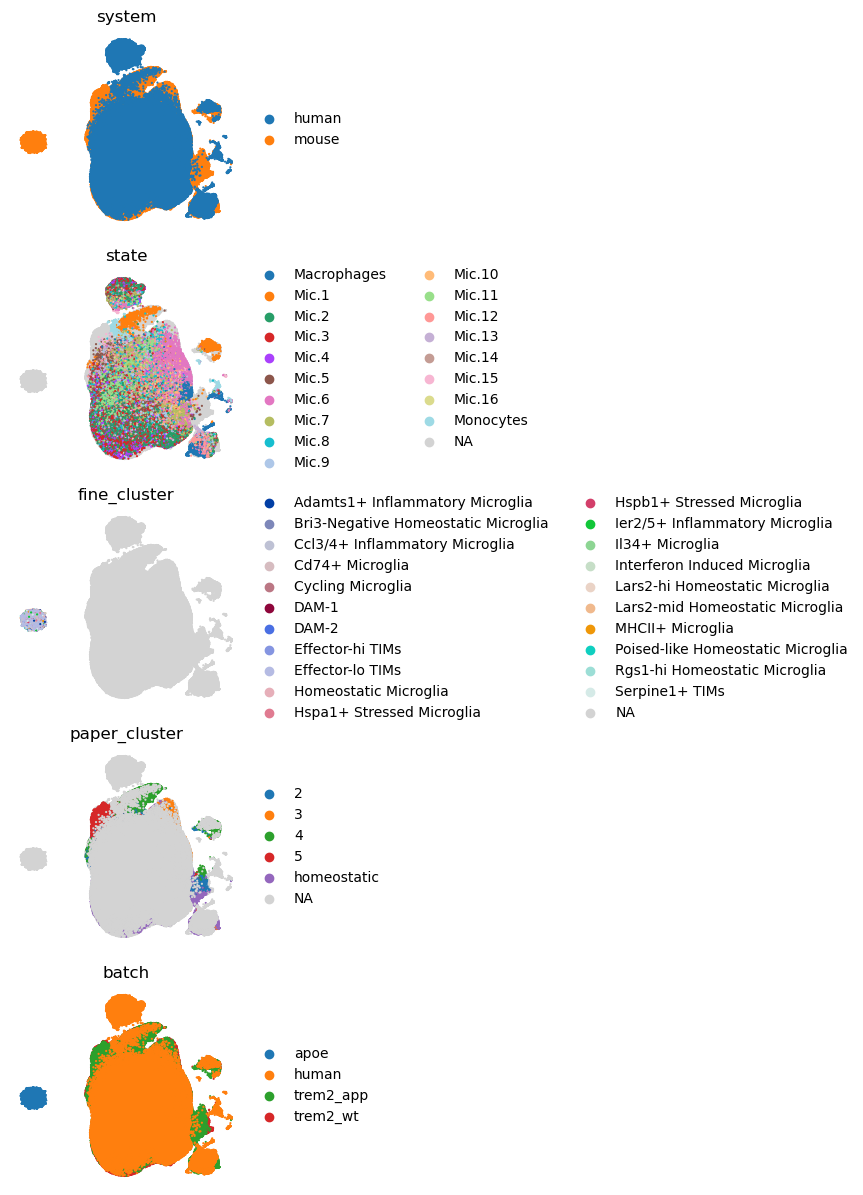

In [4]:

# Obs columns to color by
cols = ["system", "state", 'fine_cluster', 'paper_cluster', 'batch']

# One plot per obs column used for coloring
fig, axs = plt.subplots(len(cols), 1, figsize=(3, 3 * len(cols)))
for col, ax in zip(cols, axs, strict=False):
    sc.pl.embedding(
        embed,
        "X_umap",
        color=col,
        s=10,
        ax=ax,
        show=False,
        sort_order=False,
        frameon=False,
    )

In [ ]:
# show umap of before integration, is apoe just more far away?

AnnData object with n_obs × n_vars = 287072 × 15
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'X', 'sample_id', 'sample_name', 'parent_id', 'subject_id', 'description', 'species', 'sex', 'sample_source', 'sample_type', 'organ', 'region', 'cell_type', 'strain', 'age', 'age_unit', 'batch', 'genotype', 'treatment', 'treatment_dose', 'treatment_dose_unit', 'treatment_duration', 'treatment_duration_unit', 'takedown_date', 'percent.mito', 'integrated_snn_res.0.1', 'seurat_clusters', 'sample', 'group', 'dosing_solution_code', 'time_point', 'antibody_dose', 'cohort', 'integrated_snn_res.0.2', 'integrated_snn_res.0.4', 'paper_cluster', 'nCount_HTO', 'nFeature_HTO', 'percent.mt', 'miQC.probability', 'miQC.keep', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.1.4', 'clust_id', 'microglia', 'subclust_id', 'fine_cluster', 'system', 'individualID', 'DoubletFinder.score', 'subset', 'class', 'state', 'projid', 'Study', 'msex', 'educ', 'race', 'spanish', 'apoe_genotype', 'age_at_visit_max', 

In [6]:
orig = sc.read_h5ad('/lustre/groups/ml01/projects/2024_microglia_zihe.zheng/integrated_data/human_mouse_not_integrated.h5ad')

In [7]:
orig

AnnData object with n_obs × n_vars = 287072 × 2046
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'X', 'sample_id', 'sample_name', 'parent_id', 'subject_id', 'description', 'species', 'sex', 'sample_source', 'sample_type', 'organ', 'region', 'cell_type', 'strain', 'age', 'age_unit', 'batch', 'genotype', 'treatment', 'treatment_dose', 'treatment_dose_unit', 'treatment_duration', 'treatment_duration_unit', 'takedown_date', 'percent.mito', 'integrated_snn_res.0.1', 'seurat_clusters', 'sample', 'group', 'dosing_solution_code', 'time_point', 'antibody_dose', 'cohort', 'integrated_snn_res.0.2', 'integrated_snn_res.0.4', 'paper_cluster', 'nCount_HTO', 'nFeature_HTO', 'percent.mt', 'miQC.probability', 'miQC.keep', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.1.4', 'clust_id', 'microglia', 'subclust_id', 'fine_cluster', 'system', 'individualID', 'DoubletFinder.score', 'subset', 'class', 'state', 'projid', 'Study', 'msex', 'educ', 'race', 'spanish', 'apoe_genotype', 'age_at_visit_max'

In [8]:
sc.pp.pca(orig)
sc.pp.neighbors(orig)
sc.tl.umap(orig)

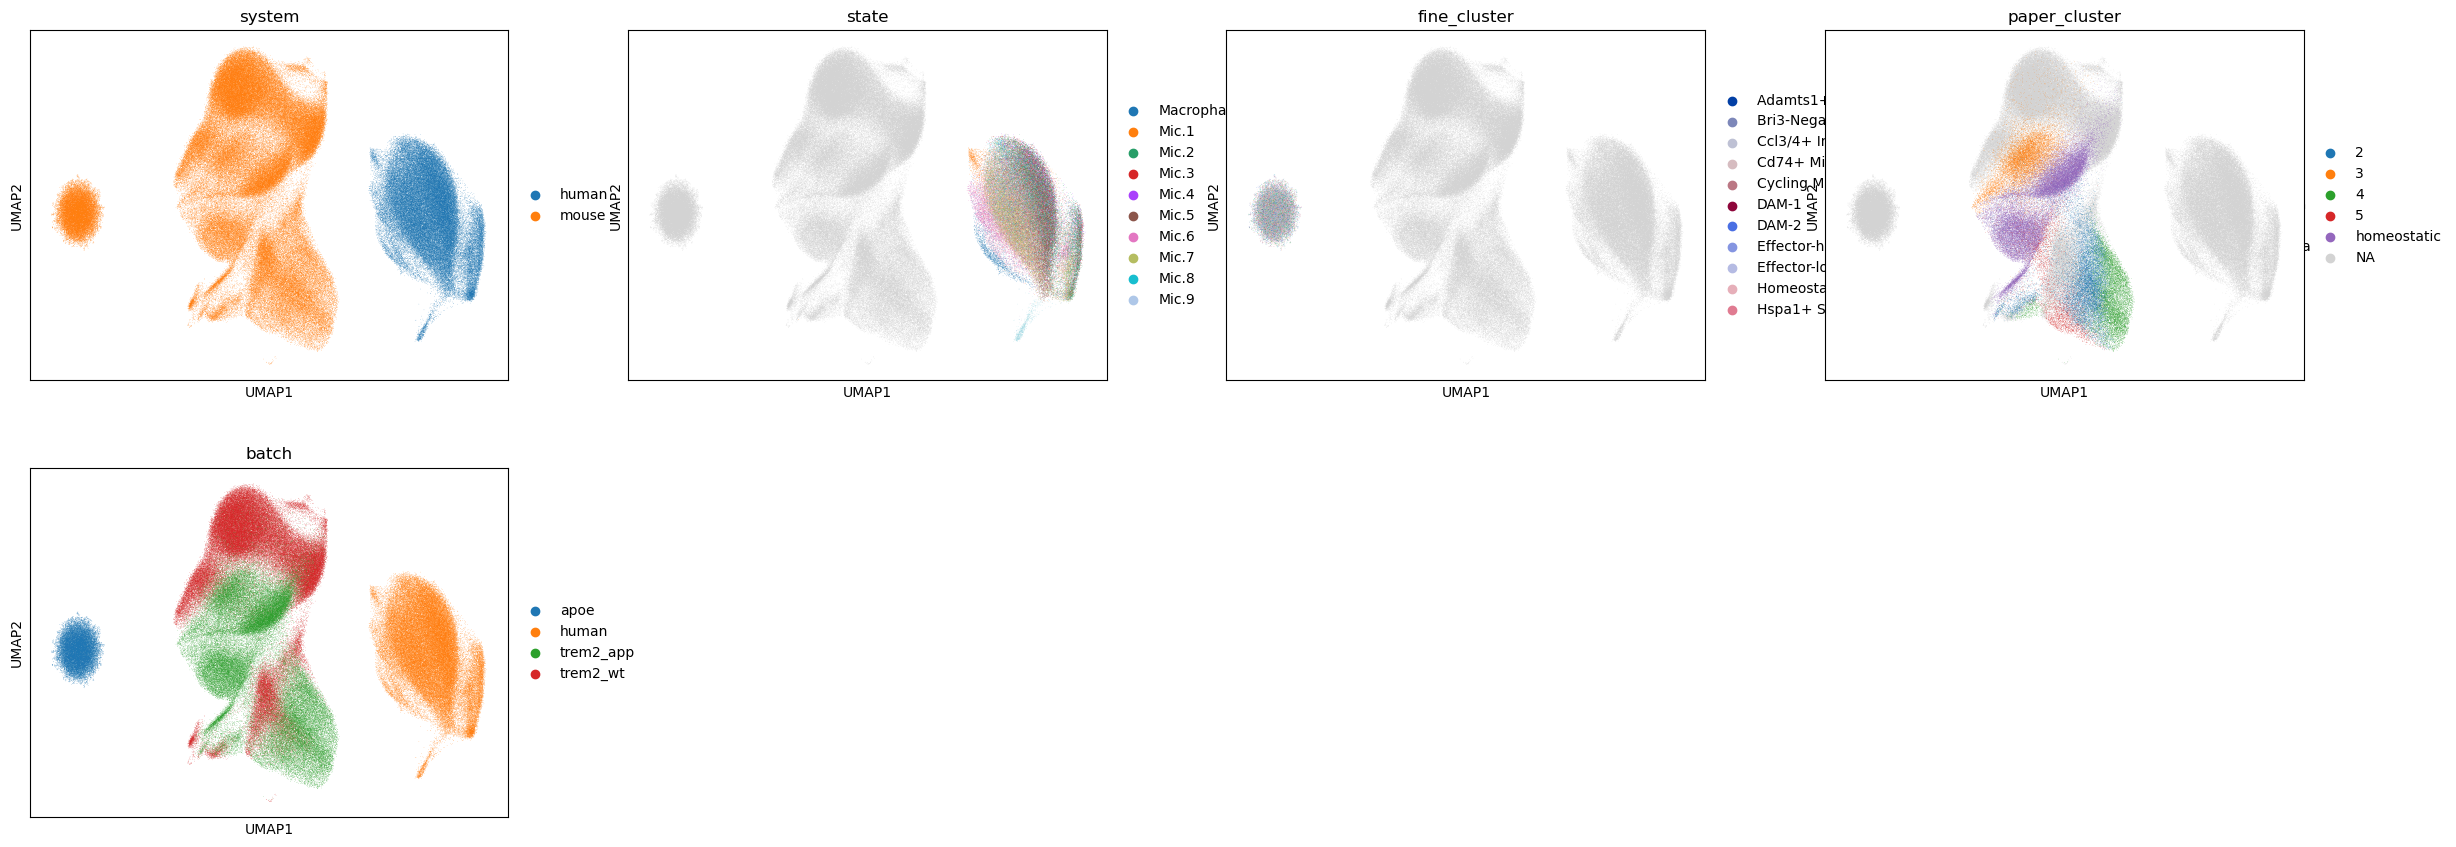

In [10]:
sc.pl.umap(orig, color = ["system", "state", 'fine_cluster', 'paper_cluster', 'batch'])